In [8]:
import json
import random
import logging
import os

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import spatial

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from transformers import *
from transformers import AutoTokenizer

import transformers
from bert_score import score

transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [9]:
# loading datasets
with open("./wikilarge.json", encoding="utf-8") as f:
    wikilarge = json.load(f)

In [10]:
print(wikilarge[11])

{'input': 'It was originally thought that the debris thrown up by the collision filled in the smaller craters .', 'reference': ['It was thought that the debris thrown up by the collision filled the smaller craters.', 'Originally, it was thought that smaller craters were filled in with debris from the collision.', 'It was originally thought that the debris thrown up by the crash filled in the smaller craters.', 'Originally people thought that the debris thrown up by the collision filled in the smaller craters.', 'It was originally thought that the scattered remains of the collission filled the smaller circulare depressions in the ground.', 'In the beginning, it was thought that the pieces thrown up by the crash filled in the smaller holes.', 'It was originally thought that the debris thrown up by the collision filled in the smaller craters .', 'It was originally thought that the debris thrown up by the collision filled in the smaller craters .']}


In [11]:
# generating adversarial
def drop_noise(targets, drop_ratio):
    # drop_ratio = 0.1, see https://arxiv.org/pdf/1711.00043.pdf
    drop_set = []
    
    for target in targets:
        temp = []
        tokens = word_tokenize(target)
        for token in tokens:
            check = random.randint(0,10)
            if check >= drop_ratio * 10:
                temp.append(token)
                
        drop_set.append(" ".join(temp))
    
    return drop_set
        

def addition_noise(targets, dataset, ext_ratio):
    # ext_ratio = [0.4, 0.6]
    # see sentence compression work @ https://www.aclweb.org/anthology/K18-1040.pdf
    add_set = []
    
    for target in targets:
        tokens = word_tokenize(target)
        temp = tokens
        sample_len = int(len(tokens)*random.randint(40, 60)/100)
        for i in range(sample_len):
            sent_ind = random.randint(0, len(dataset)-1)
            ext_sent = dataset[0]
            ext_tokens = word_tokenize(ext_sent)
            ext_token = ext_tokens[random.randint(0, len(ext_tokens)-1)]
            temp.append(ext_token)
            
        add_set.append(" ".join(temp))
        
    return add_set


def shuffle_noise(targets, keep_num):
    # keep_num = 3, see https://arxiv.org/pdf/1711.00043.pdf
    shuffle_set = []
    
    for target in targets:
        tokens = word_tokenize(target)
        this_keep_num = keep_num - 1
        while this_keep_num < keep_num:
            new_tokens = tokens
            random.shuffle(new_tokens)
            count = 0
            if len(tokens) < keep_num:
                break
            
            for i, tok in enumerate(tokens):
                if tok == new_tokens[i]:
                    count += 1
                    
            this_keep_num = count
            
        shuffle_set.append(" ".join(new_tokens))
        
    return shuffle_set


def substitution_noise(targets, simpleppdb, threshold):
    # todo
    return True

In [12]:
allsents = []
for datapiece in wikilarge[:100]:
    allsents.append(datapiece["input"])
    for ref_sent in datapiece["reference"]:
        allsents.append(ref_sent)
        
targets = [wikilarge[11]["input"]]
print(targets)
print(drop_noise(targets, 0.3))
print(addition_noise(targets, allsents, [0.4, 0.6]))
print(shuffle_noise(targets, keep_num=3))

['It was originally thought that the debris thrown up by the collision filled in the smaller craters .']
['It thought that the debris thrown by the smaller .']
['It was originally thought that the debris thrown up by the collision filled in the smaller craters . composed One armed of Sudan conflicts . composed militia']
['smaller in originally by It debris thought the the craters . up the that collision filled thrown was']


In [13]:
# create deep representation
class BertEncoder(BertModel):
    # here we use the average, we could also use the CLS token
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.lm = BertModel(config)
        # self.embedding_size = 300

    def forward(self, sents):
        # forwarding the sents and use the average embedding as the results

        representation  = self.lm(sents) #.unsqueeze(0)) # num_sent * sent_len * emb
        # print(representation[0].size)
        sent_representation = torch.mean(representation[0], dim=1) # num_sent * emb
        # print(sent_representation.shape)
        # overall_representation = torch.mean(sent_representation, dim=0) # 1 *  emb
        # output size: 1024

        return sent_representation

def encode_sents(sents, tokenizer, model):
    # we do not use batch since the length might vary a lot
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output = []
    # TODO, change to batches
    for sent in sents:
        # encoding
        batch = tokenizer.encode(sent, add_special_tokens=True, return_tensors="pt")

        # examples = torch.tensor(tokenized_sents).to(device)
        hiddens = model(batch).detach().numpy()
        output.extend(hiddens)
    
    return output

In [14]:
config = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(config)
bert = BertEncoder.from_pretrained(config)

In [36]:
selection = 11

targets = [wikilarge[selection]["input"]]
hiddens = encode_sents(targets, tokenizer,bert)
print(hiddens)
refs = wikilarge[selection]["reference"]
ref_hiddens = encode_sents(refs, tokenizer,bert)

noise = []
noise.extend(drop_noise(targets, 0.3))
noise.extend(addition_noise(targets, allsents, [0.4, 0.6]))
noise.extend(shuffle_noise(targets, keep_num=3))

# noise.extend(drop_noise(refs, 0.3))
# noise.extend(addition_noise(refs, allsents, [0.4, 0.6]))
# noise.extend(shuffle_noise(refs, keep_num=3))

noise_hiddens = encode_sents(noise, tokenizer, bert)

[array([ 1.0965388 ,  0.95151126,  0.85436314, ..., -0.4808751 ,
        2.4612558 , -0.1997606 ], dtype=float32)]


In [37]:
# checking cosine dist
print("Checking Input")
for hidden in hiddens:
    print("Input vs Reference")
    avg = []
    for ref_hidden in ref_hiddens:
        score = 1 - spatial.distance.cosine(hidden, ref_hidden)
        avg.append(score)
        # print(score)
    print("Average: ", np.mean(avg))
        
    print("Input vs Noise")
    avg = []
    for noise_hidden in noise_hiddens:
        score = 1 - spatial.distance.cosine(hidden, noise_hidden)
        avg.append(score)
        # print(score)
    print("Average: ", np.mean(avg))

Checking Input
Input vs Reference
Average:  0.9915816932916641
Input vs Noise
Average:  0.9849029978116354


In [38]:
# PCA and visualization
X = []
X.extend(hiddens)
X.extend(ref_hiddens)
X.extend(noise_hiddens)

sub_X = []
for vec in X:
    sub_X.append(vec-hiddens[0])

# X.append(np.mean(hiddens, axis=0))
# X.append(np.mean(ref_hiddens, axis=0))
# X.append(np.mean(noise_hiddens, axis=0))

X_ref = [] #["Input", "Reference", "Hidden"]
for i in range(len(hiddens)):
    X_ref.append("Input")
for i in range(len(ref_hiddens)):
    X_ref.append("Reference")
for i in range(len(noise_hiddens)):
    X_ref.append("Noise")
    
    
pca = PCA(n_components=2)
pca.fit(sub_X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

[0.31934315 0.20394233]
[4.88404522 3.11910109]


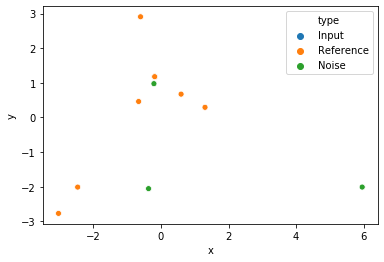

In [39]:
X_new = pca.transform(sub_X)

lst = []
for i, vec in enumerate(X_new):
    lst.append([vec[0], vec[1], X_ref[i]])
        
df = pd.DataFrame(lst, columns=["x", "y", "type"])

sns.scatterplot(data=df, x="x", y="y", hue="type")

In [ ]:
# training